In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

/Users/erickgurrola/.virtualenvs/temperatures1/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def scrape_temperatures(year, month):
    """
    Scrape the average daily temperatures for a given year and month from the specified website.
    """
    url = f"https://www.tutiempo.net/clima/{month:02d}-{year}/ws-766120.html"
    response = requests.get(url)
    
    if response.status_code != 200:
        return None

    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'class': 'medias mensuales numspan'})
    
    if not table:
        return None

    rows = table.find_all('tr')[1:]  # Exclude the header row

    temperatures = []
    for row in rows:
        cols = row.find_all('td')
        if len(cols) >= 3:
            day = cols[0].text.strip()
            temp = cols[2].text.strip()
            if day and temp:
                temperatures.append([year, month, int(day), temp])

    return temperatures

In [3]:
# Initialize a list to store all the temperature data
uptoyear = 2024
csv_file_path = f'guadalajara_temperatures_{uptoyear}.csv'

all_temperatures = []


# Iterate through each year and month since January 2000
for year in range(1992, uptoyear+1):
    for month in range(1, 13):
        temp_data = scrape_temperatures(year, month)
        if temp_data:
            all_temperatures.extend(temp_data)
        time.sleep(0.05)
    

# Creating a DataFrame from the scraped data
df_temperatures = pd.DataFrame(all_temperatures, columns=['Year', 'Month', 'Day', 'Temperature'])


df_temperatures.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")

Data saved to guadalajara_temperatures_2024.csv


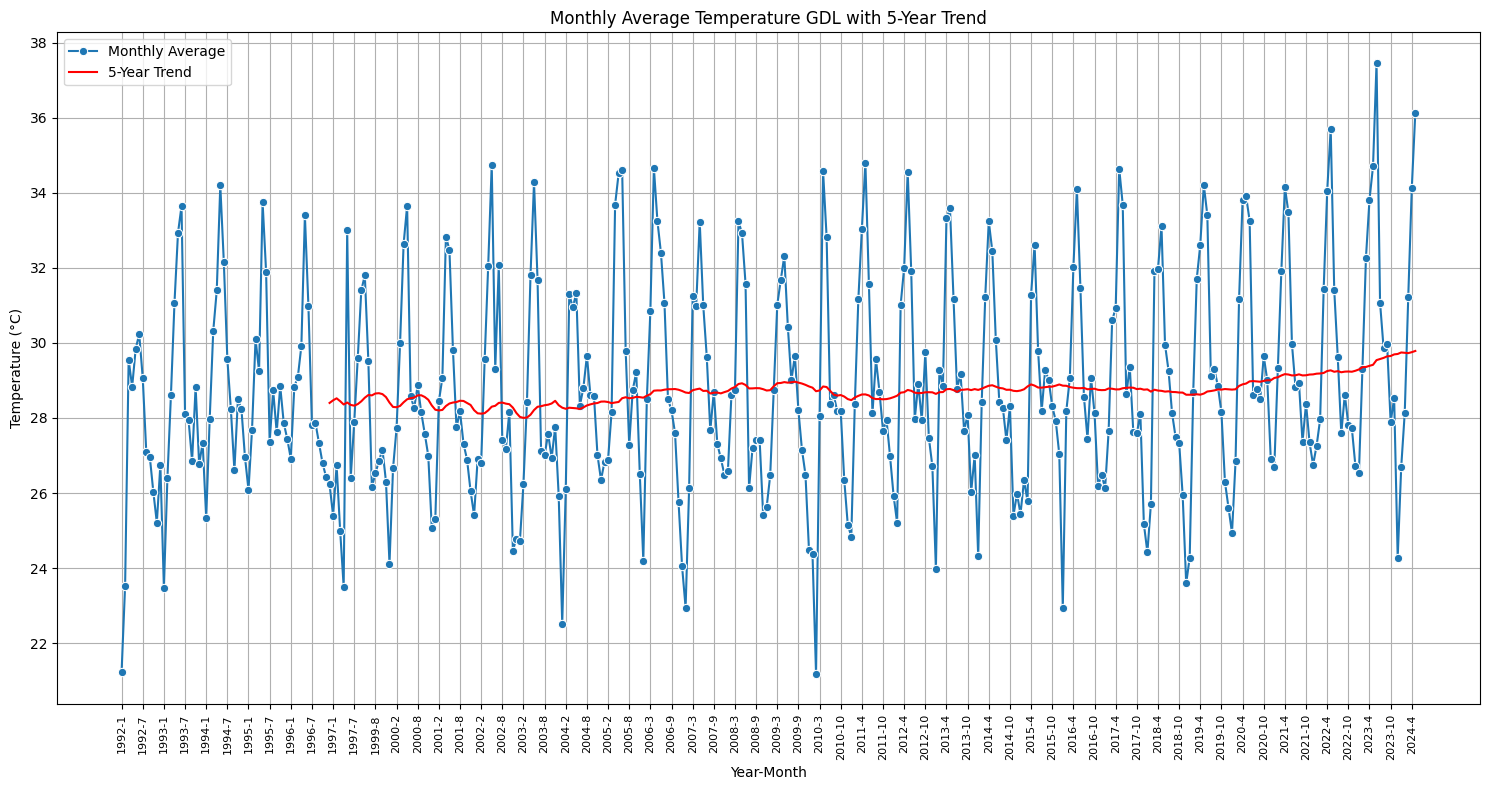

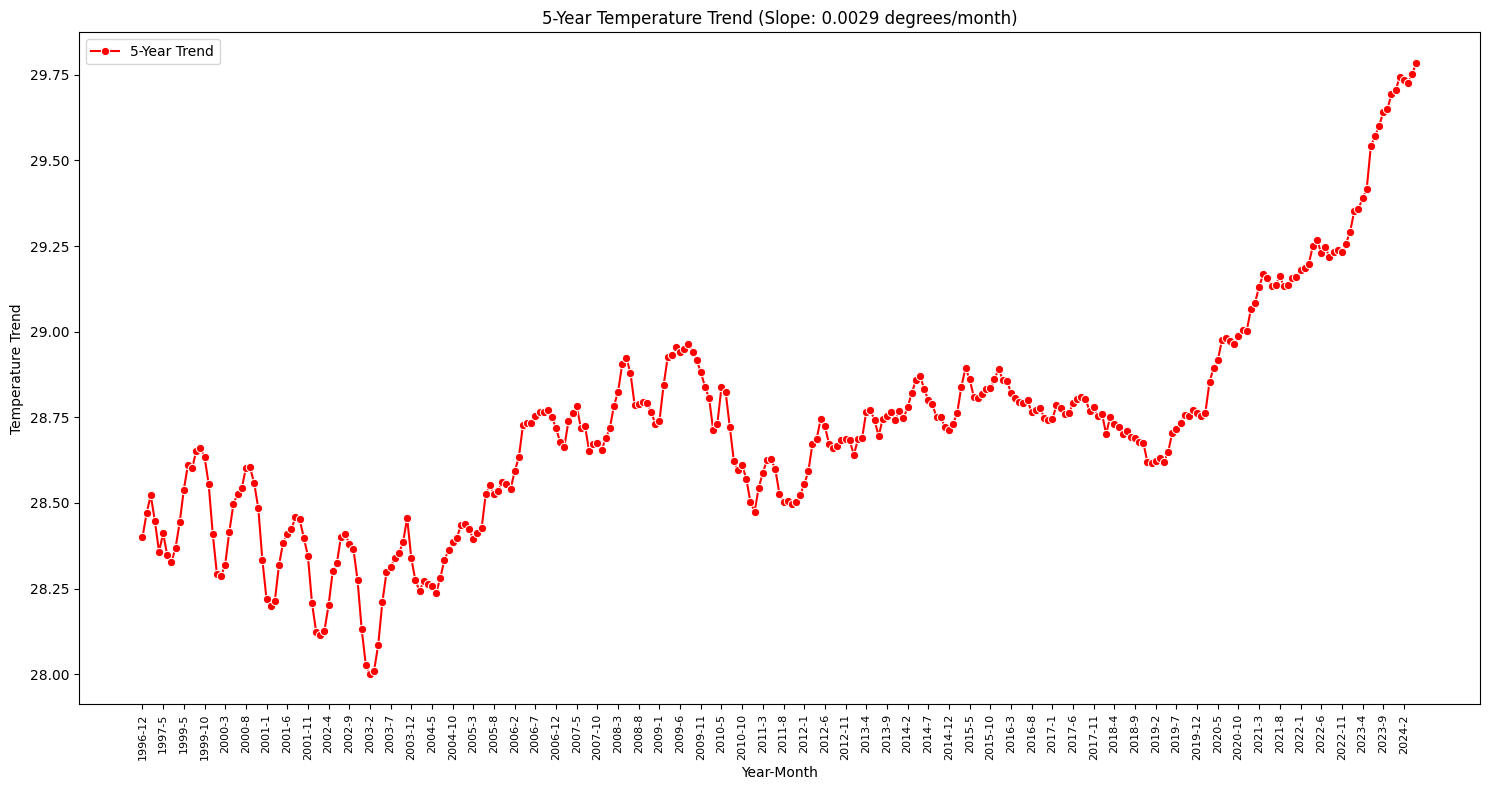

In [4]:
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import linregress
# Let's try again to generate the graph using the newly provided data file.

# Reload the newly provided data
file_path_new = csv_file_path
temperature_data_new = pd.read_csv(file_path_new)

# Replace '-' with NaN in the temperature column and convert to numeric
temperature_data_new['Temperature'] = pd.to_numeric(temperature_data_new['Temperature'], errors='coerce')

# Calculating the yearly average temperatures
yearly_avg_temp_new = temperature_data_new.groupby(['Year','Month'])['Temperature'].mean().reset_index()

# Adding a 5-year trend line
yearly_avg_temp_new['Trend'] = yearly_avg_temp_new['Temperature'].rolling(window=60).mean()
# Creating a new column for plotting
yearly_avg_temp_new['YearMonth'] = yearly_avg_temp_new['Year'].astype(str) + '-' + yearly_avg_temp_new['Month'].astype(str)


# Plotting the graph
plt.figure(figsize=(15, 8))
sns.lineplot(x='YearMonth', y='Temperature', data=yearly_avg_temp_new, marker='o', label='Monthly Average')
sns.lineplot(x='YearMonth', y='Trend', data=yearly_avg_temp_new, color='red', label='5-Year Trend')

# Improving x-axis labels
num_labels = len(yearly_avg_temp_new['YearMonth'])
plt.xticks(ticks=range(0, num_labels, 6), labels=yearly_avg_temp_new['YearMonth'][::6], rotation=90, fontsize=8)


# Adding titles and labels
plt.title('Monthly Average Temperature GDL with 5-Year Trend')
plt.xlabel('Year-Month')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot to a file and then display it
extended_avg_trend_graph_file_path = 'Montly average and 5y trend GDL.png'
plt.savefig(extended_avg_trend_graph_file_path)
plt.show()



# Calculating the slope of the 5-year trend line
slope, intercept, r_value, p_value, std_err = linregress(yearly_avg_temp_new.dropna(subset=['Trend']).index, yearly_avg_temp_new.dropna(subset=['Trend'])['Trend'])

# Creating a new DataFrame for the trend plot
trend_data = yearly_avg_temp_new.dropna(subset=['Trend'])

# Plotting the trend graph
plt.figure(figsize=(15, 8))
sns.lineplot(x='YearMonth', y='Trend', data=trend_data, color='red', label='5-Year Trend', marker='o')

# Improving x-axis labels
num_labels_trend = len(trend_data['YearMonth'])
plt.xticks(ticks=range(0, num_labels_trend, 5), labels=trend_data['YearMonth'][::5], rotation=90, fontsize=8)

# Adding titles and labels with slope information
plt.title(f'5-Year Temperature Trend (Slope: {slope:.4f} degrees/month)')
plt.xlabel('Year-Month')
plt.ylabel('Temperature Trend')
plt.legend()
plt.tight_layout()
# Save the plot to a file and then display it
extended_avg_trend_graph_file_path = '5y trend GDL.png'
plt.savefig(extended_avg_trend_graph_file_path)
plt.show()





#plt.close()
